In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Contexto
Este conjunto de dados clássico contém os preços e outros atributos de quase 54.000 diamantes. É um ótimo conjunto de dados para iniciantes que estão aprendendo a trabalhar com análise e visualização de dados.

## Conteúdo
- **preco**: preço em dólares americanos (\$326--\$18.823)
- **quilate**: peso em quilates do diamante (0,2--5,01)
- **corte**: qualidade do corte (Regular, Bom, Muito Bom, Premium, Ideal)
- **cor**: cor do diamante, de J (pior) a D (melhor)
- **clareza**: uma medida de quão claro é o diamante (I1 (pior), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (melhor))
- **X**: comprimento em mm (0--10,74)
- **Y**: largura em mm (0--58,9)
- **Z**: profundidade em mm (0--31,8)
- **profundidade**: total de profundidade = z / média (x, y) = 2 * z / (x + y) (43--79)
- **Largura do topo(lg_topo)**: do topo do diamante em relação ao ponto mais largo (43--95)


In [2]:
# Creating the dataframe
diamonds_df = pd.read_csv('resources/diamonds/diamonds.csv')

In [3]:
diamonds_df.head()

,quilate,corte,cor,clareza,profundidade,lg_topo,preco,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Convertendo string para numero

In [4]:
diamonds_df['clareza'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [5]:
diamonds_df['corte'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [6]:
diamonds_df['cor'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [7]:
def replacement_column_str_to_int(column:str):
    substituicao = {value: index + 1 for index, value in enumerate(diamonds_df[column].unique())}
    # Substituindo os valores na coluna 'corte'
    diamonds_df[column] = diamonds_df[column].map(substituicao)
    diamonds_df[column].unique()

In [8]:
for column in ['clareza', 'corte','cor']:
    replacement_column_str_to_int(column)

## Mapa de calor

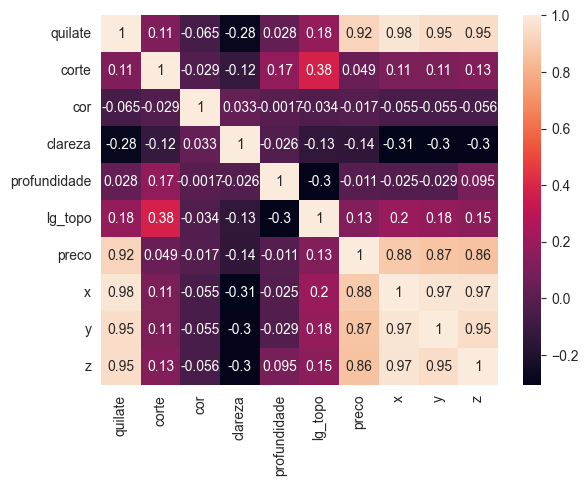

In [9]:
sns.heatmap(diamonds_df.corr(), annot = True);

> Segundo o mapa da calor as colunas 'cor','clareza','profundidade','corte','lg_topo'  não tem ligação forte com o preço, que pode ser descartado para limpar os dados

In [10]:
diamonds_df.drop(['cor','clareza','profundidade','corte','lg_topo'],inplace=True,axis=1)
diamonds_df.head()

,quilate,preco,x,y,z
0,0.23,326,3.95,3.98,2.43
1,0.21,326,3.89,3.84,2.31
2,0.23,327,4.05,4.07,2.31
3,0.29,334,4.20,4.23,2.63
4,0.31,335,4.34,4.35,2.75


## Linpando os dados

In [11]:
def remove_outliers(column:str):
    dados = np.array(diamonds_df[column])
    
    q1 = np.percentile(dados, 25)
    q3 = np.percentile(dados, 75)
    iqr = q3 - q1
    
    # Limite inferior e superior
    limite_inf = q1 - 1.5 * iqr
    limite_sup = q3 + 1.5 * iqr
    
    #Separação dos dados que não estão dentro dos limites
    outliers=np.where((dados<limite_inf)|(dados>limite_sup))[0]
    #Removendo outliers
    diamonds_df.loc[outliers, column] =   np.nan


In [12]:
for column in diamonds_df.columns:
    remove_outliers(column)

In [13]:
diamonds_df = diamonds_df.dropna(how='all')

## Normalizando os dados

In [14]:
from sklearn.impute import SimpleImputer

# Criar o imputador (usando a estratégia de média, mas isso pode ser alterado)
imputador = SimpleImputer(missing_values=np.nan, strategy='mean')

# Aplicar o imputador ao DataFrame inteiro, mantendo as colunas originais
diamonds_df = pd.DataFrame(imputador.fit_transform(diamonds_df), columns=diamonds_df.columns)

diamonds_df

,quilate,preco,x,y,z
0,0.23,326.0,3.95,3.98,2.43
1,0.21,326.0,3.89,3.84,2.31
2,0.23,327.0,4.05,4.07,2.31
3,0.29,334.0,4.20,4.23,2.63
4,0.31,335.0,4.34,4.35,2.75
...,...,...,...,...,...
53922,0.72,2757.0,5.75,5.76,3.50
53923,0.72,2757.0,5.69,5.75,3.61
53924,0.70,2757.0,5.66,5.68,3.56
53925,0.86,2757.0,6.15,6.12,3.74


## Treinando o modelo de regressão

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Separar variáveis independentes (X) e dependentes (y)
y = diamonds_df['preco'].values.ravel()  # Usar ravel() para converter em vetor 1D
X = diamonds_df.drop('preco', axis=1)

# Padronização dos dados com média 0 e desvio padrão 1
scaler_y = StandardScaler()
scaler_x = StandardScaler()

y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # Ajuste e converta em vetor 1D
X_scaled = scaler_x.fit_transform(X)

# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=0)

# Reduzindo a dimencionalidade para de 4 para 3
pca = PCA(n_components=3, whiten=True, random_state=42)
model = DecisionTreeRegressor()

pipeline = make_pipeline(pca, model)

grid_search = GridSearchCV(pipeline, {}, n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Testando modelo

In [18]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_pred = best_model.predict(x_test)
# Inverter a padronização das previsões
y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Inverter a padronização dos valores reais para comparação
# Certifique-se de que y_test também esteja em 2D
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Avaliar o desempenho do modelo usando o erro quadrático médio
mse = mean_squared_error(y_test_real, y_pred_real)

# Mostrar as previsões
print(f"Predições (reais): {y_pred_real.flatten()[:5]}")  # Mostrando as primeiras 5 previsões


mae = mean_absolute_error(y_test_real, y_pred_real)
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_real, y_pred_real)


print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

Predições (reais): [ 900. 1550. 2362.  666. 7550.]
MAE: 900.56
MSE: 3135330.83
RMSE: 1770.69
MAPE: 0.27
